# Advanced Defect/Carrier Concentration Analysis
## Interface with `py_sc_fermi`

To extend the analysis available in doped, we include an optional interface with the [`py_sc_fermi`](https://github.com/bjmorgan/py-sc-fermi) code for analysis of self-consistent Fermi energies and defect concentrations. We'll go through how to use the interface to study defect concentrations in the CdTe.

The majority of the functionality of this interface is contained within the `FermiSolver` class, for which there are two subclasses, the `FermiSolverPyScFermi` and `FermiSolverDoped`. Each provides similar functionaility, but the `FermiSolverPyScFermi` class extends what is possible with doped, with some different analysis functionality which we will describe in this notebook.

### CdTe: Defect Concentrations

We'll start by using the familiar binary CdTe example to outline the basic functionality of the FermiSolvers. The first step is simply to generate the `FermiSolver` objects

In [2]:
from doped.interface.fermi_solver import FermiSolverDoped, FermiSolverPyScFermi
from monty.serialization import loadfn
import matplotlib.pyplot as plt
import pandas as pd

# we can use the doped style file to make all our plots look consistent
style_file = "../doped/utils/doped.mplstyle"
plt.style.use(style_file)

# we need to specify the path to the vasprun.xml(.gz) file
# that was used for the DOS calculation. This is because
# we need to accurately account for the electronic carrier concentrations
# as well as the defect concentrations to determine the Fermi level
vasprun_path = "CdTe/CdTe_prim_k181818_NKRED_2_vasprun.xml.gz"

# the DefectThermodynamics object contains all the information about the
# defect formation energies, degeneracy factors and transition levels. 
# It will underpin both the doped and py-sc-fermi solvers
thermodynamics = loadfn("CdTe/CdTe_LZ_thermo_wout_meta.json")

# and the chemical potentials can then be used to specify the
# defect formation energies under different conditions, and act as a parameter
# space we can scan over to interrogate the defect concentrations
chemical_potentials = loadfn("CdTe/CdTe_chempots.json")

# initialize the FermiSolver objects
fs = FermiSolverDoped(defect_thermodynamics=thermodynamics, 
                      bulk_dos_vr=vasprun_path)
py_fs = FermiSolverPyScFermi(defect_thermodynamics=thermodynamics, 
                             bulk_dos_vr=vasprun_path)

32


Once we have the `FermiSolvers`, perhaps the simplest parameter to scan over is the temperature, and we can do so as follows. We will use this as an example to show that the two solvers get equivalent results

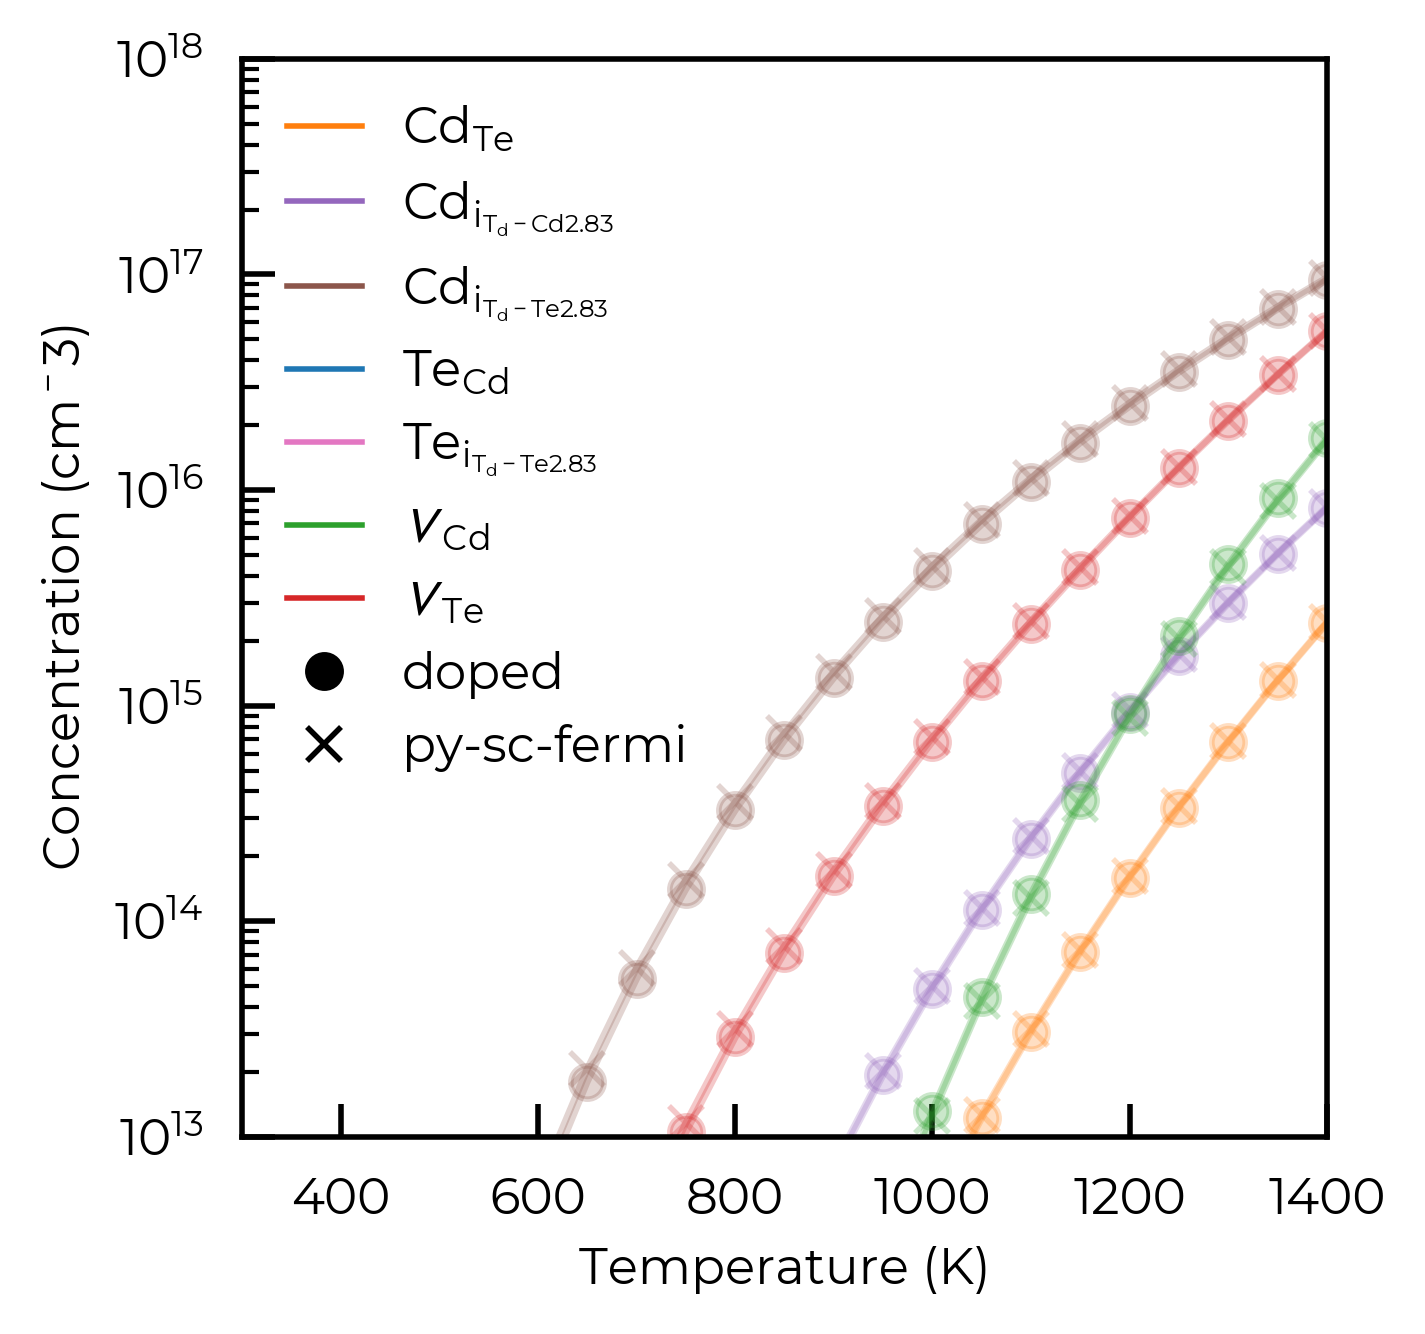

In [2]:
# define a range of temperatures to scan over
import numpy as np
from doped.utils.plotting import format_defect_name

temperatures = range(300, 1410, 50)  # temperatures to consider, in K

defect_colors = {"Te_Cd": "C0", "Cd_Te": "C1", "v_Cd": "C2", "v_Te": "C3", 
                 "Cd_i_Td_Cd2.83": "C4", "Cd_i_Td_Te2.83": "C5", "Te_i_Td_Te2.83": "C6"}

# the scan_temperature method can be used to scan over a range of temperatures
# and generate a DataFrame containing the defect concentrations, carrier concentrations,
# and Fermi levels at each temperature
temperature_df = fs.scan_temperature(chemical_potentials["limits_wrt_el_refs"]["Cd-CdTe"],
                                    temperature_range = temperatures)
temperature_df_py = py_fs.scan_temperature(chemical_potentials["limits"]["Cd-CdTe"],
                                        temperature_range=temperatures)

temperature_df["backend"] = "doped"
temperature_df_py["backend"] = "py-sc-fermi"

plot_data = pd.concat([temperature_df, temperature_df_py])

# Create a unique list of defects in the DataFrame
unique_defects = temperature_df.index.unique()

fig, ax = plt.subplots()

# loop over the unique defects and plot the defect concentrations
# as a function of temperature, for both the doped and py-sc-fermi backends
for defect in unique_defects:
    defect_df = plot_data.loc[defect]
    
    for backend in ["doped", "py-sc-fermi"]:
        defect_df_backend = defect_df[defect_df["backend"] == backend]
        ax.plot(defect_df_backend["Temperature"], 
                defect_df_backend["Concentration (cm^-3)"], 
                label=format_defect_name(defect, include_site_info_in_name=True, wout_charge=True), 
                color=defect_colors[defect], 
                marker="o" if backend == "doped" else "x",
                alpha = 0.25)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Concentration (cm${^-3}$)")

ax.set_xlim(300, 1400)
ax.set_ylim(1e13, 1e18)
ax.set_yscale("log")

custom_lines = [plt.Line2D([0], [0], color=defect_colors[defect], lw=1) for defect in unique_defects]
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="o", linestyle="None", label="doped"))
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="x", linestyle="None", label="py-sc-fermi"))
ax.legend(custom_lines, 
          [f"{format_defect_name(defect, include_site_info_in_name=True, wout_charge=True)}" for defect in unique_defects] + ["doped", "py-sc-fermi"],
          frameon=False)

plt.show()

To continue to show the functionality of the FermiSolver, we'll show how we can generate a Brouwer-digaram--like figure, with defect concentrations shown as a function of chemical potentials.

Some additional notes of the FermiSolver objects here:

- all of the parameter-scanning functionaility accepts a `processes` argument, which allows the user to use multiprocessing to calculate the number of cores to parallelise the scan over.
- each of the arguments can accept `annealing_temperatures` and `quenching_temperatures` arguments instead of `temperature`. These will carry out "frozen-defect" calculations between these temperatures as discussed in the [defect thermodynamics tutorial](https://doped.readthedocs.io/en/latest/thermodynamics_tutorial.html).

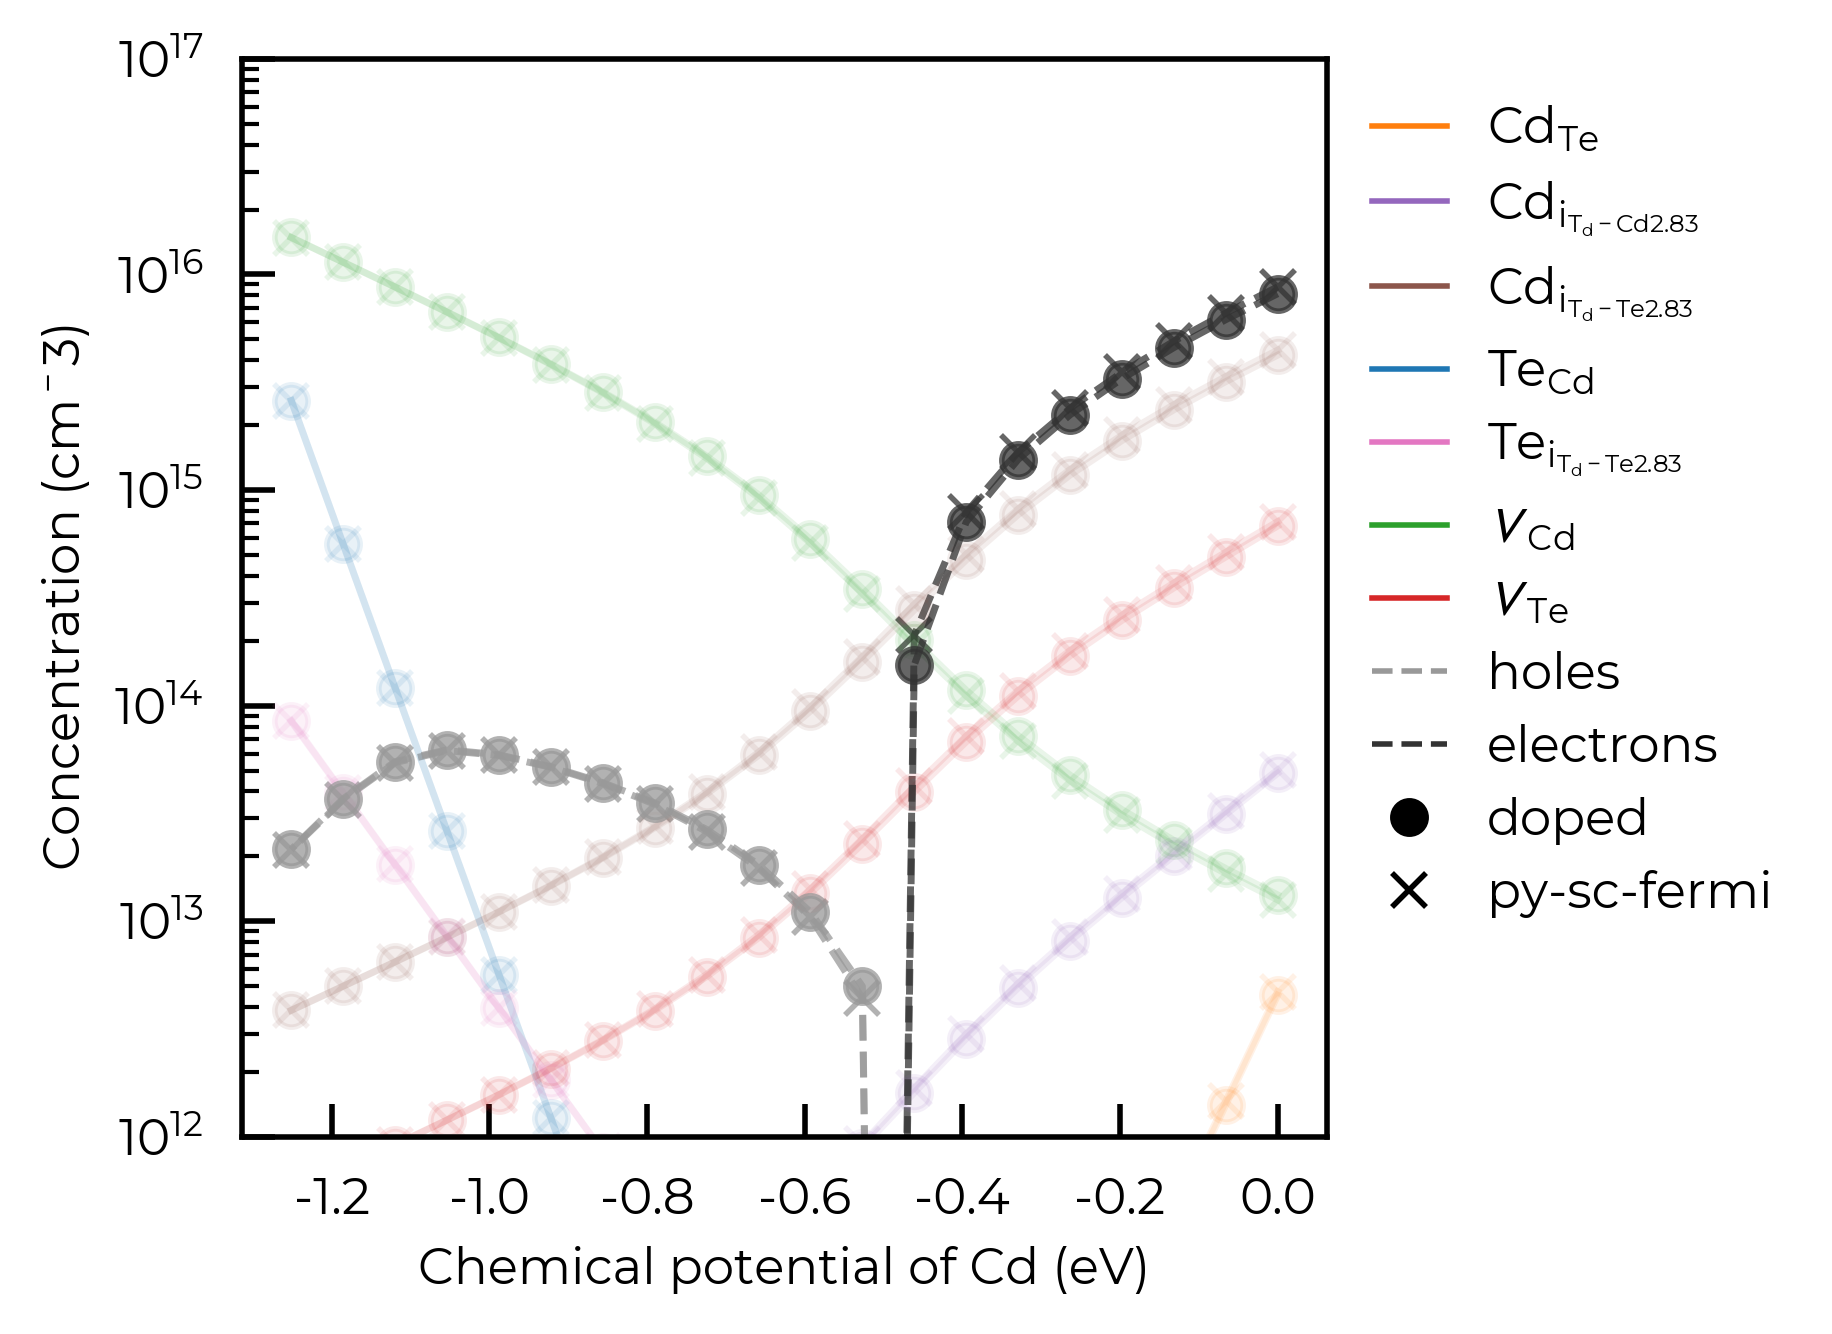

In [3]:
# scan between the Cd and Te rich limits to see how the defect concentrations
# change as a function of chemical potential
mu_df = py_fs.interpolate_chemical_potentials(chem_pot_start=chemical_potentials["limits"]["Cd-CdTe"], 
                                           chem_pot_end=chemical_potentials["limits"]["CdTe-Te"], 
                                           n_points=20, annealing_temperature=1000, quenching_temperature = 300,
                                           processes=4)
mu_df_doped = fs.interpolate_chemical_potentials(chem_pot_start=chemical_potentials["limits_wrt_el_refs"]["Cd-CdTe"],
                                                    chem_pot_end=chemical_potentials["limits_wrt_el_refs"]["CdTe-Te"],
                                                    n_points=20, annealing_temperature=1000, quenching_temperature=300,
                                                    processes=4)

# we'll keep the py-sc-fermi and doped comparison going
mu_df["backend"] = "py-sc-fermi"
mu_df_doped["backend"] = "doped"
mu_df = pd.concat([mu_df, mu_df_doped])

fig, ax = plt.subplots()

# loop over the unique defects and plot the defect concentrations
for backend in ["py-sc-fermi", "doped"]:
    for defect in unique_defects:
        defect_df = mu_df.loc[defect]
        defect_df_backend = defect_df[defect_df["backend"] == backend]
        if backend == "py-sc-fermi":
            defect_df_backend["Cd"] -= chemical_potentials["elemental_refs"]["Cd"]
        ax.plot(defect_df_backend["Cd"], 
            defect_df_backend["Concentration (cm^-3)"], 
            label=format_defect_name(defect, include_site_info_in_name=True, wout_charge=True), 
            color=defect_colors[defect], 
            marker="o" if backend == "doped" else "x",
            alpha = 0.1)
    ax.plot(defect_df_backend["Cd"], 
            defect_df_backend["Holes (cm^-3)"], 
            marker="o" if backend == "doped" else "x", 
            linestyle="--", 
            alpha = 0.75,
            color = "#999999")
    ax.plot(defect_df_backend["Cd"], 
            defect_df_backend["Electrons (cm^-3)"], 
            marker="o" if backend == "doped" else "x", 
            linestyle="--",
            alpha = 0.75, 
            color = "#333333")

ax.set_xlabel("Chemical potential of Cd (eV)")
ax.set_ylabel("Concentration (cm${^-3}$)")

custom_lines = [plt.Line2D([0], [0], color=defect_colors[defect], lw=1) for defect in unique_defects]
custom_lines.append(plt.Line2D([0], [0], color="#999999", lw=1, linestyle="--", label="holes"))
custom_lines.append(plt.Line2D([0], [0], color="#333333", lw=1, linestyle="--", label="electrons"))
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="o", linestyle="None", label="doped"))
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="x", linestyle="None", label="py-sc-fermi"))

plt.legend(custom_lines, 
          [f"{format_defect_name(defect, include_site_info_in_name=True, wout_charge=True)}" for defect in unique_defects] + ["holes", "electrons", "doped", "py-sc-fermi"],
          frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
plt.ylim(1e12, 1e17)
plt.yscale("log")
plt.show()

### Effective dopant concentrations

In certain cases, we would like to directly simulate the effect of adding a dopant into our system to see how it will change the defect concentrations. If we treat the dopant concentration as an additional free parameter, we can change our charge neutrality condition from

$$ 0 = \sum_{X} q[{X}^q] + [electrons] + [holes] $$

to 

$$ 0 = \sum_{X} q[{X}^q] + [electrons] + [holes] + r[M^r] $$

where $M$ is the concentration of the dopant with charge $r$. As we are treating this as a free parameter, $r[M^r]$ can be considered as single parameter, an effective dopant concentration that we can additionally scan over when investigating defect concentrations. 

This analysis can be useful for investigating the host defect response to an as-yet-unidentified dopant/impurity; predicting how the Fermi level and defect/carrier concentrations will change in response to a range of possible dopant concentrations. Or in other words, for analysing the dopability and compensation response, which can be useful for investigating potential solar cell / transparent conductor / thermoelectric / battery materials and more. 

This can be investigated in `doped` using the `effective_dopant_concentration` parameter in the Fermi level solving functions (both with `DefectThermodynamics` and the `FermiSolver` objects):

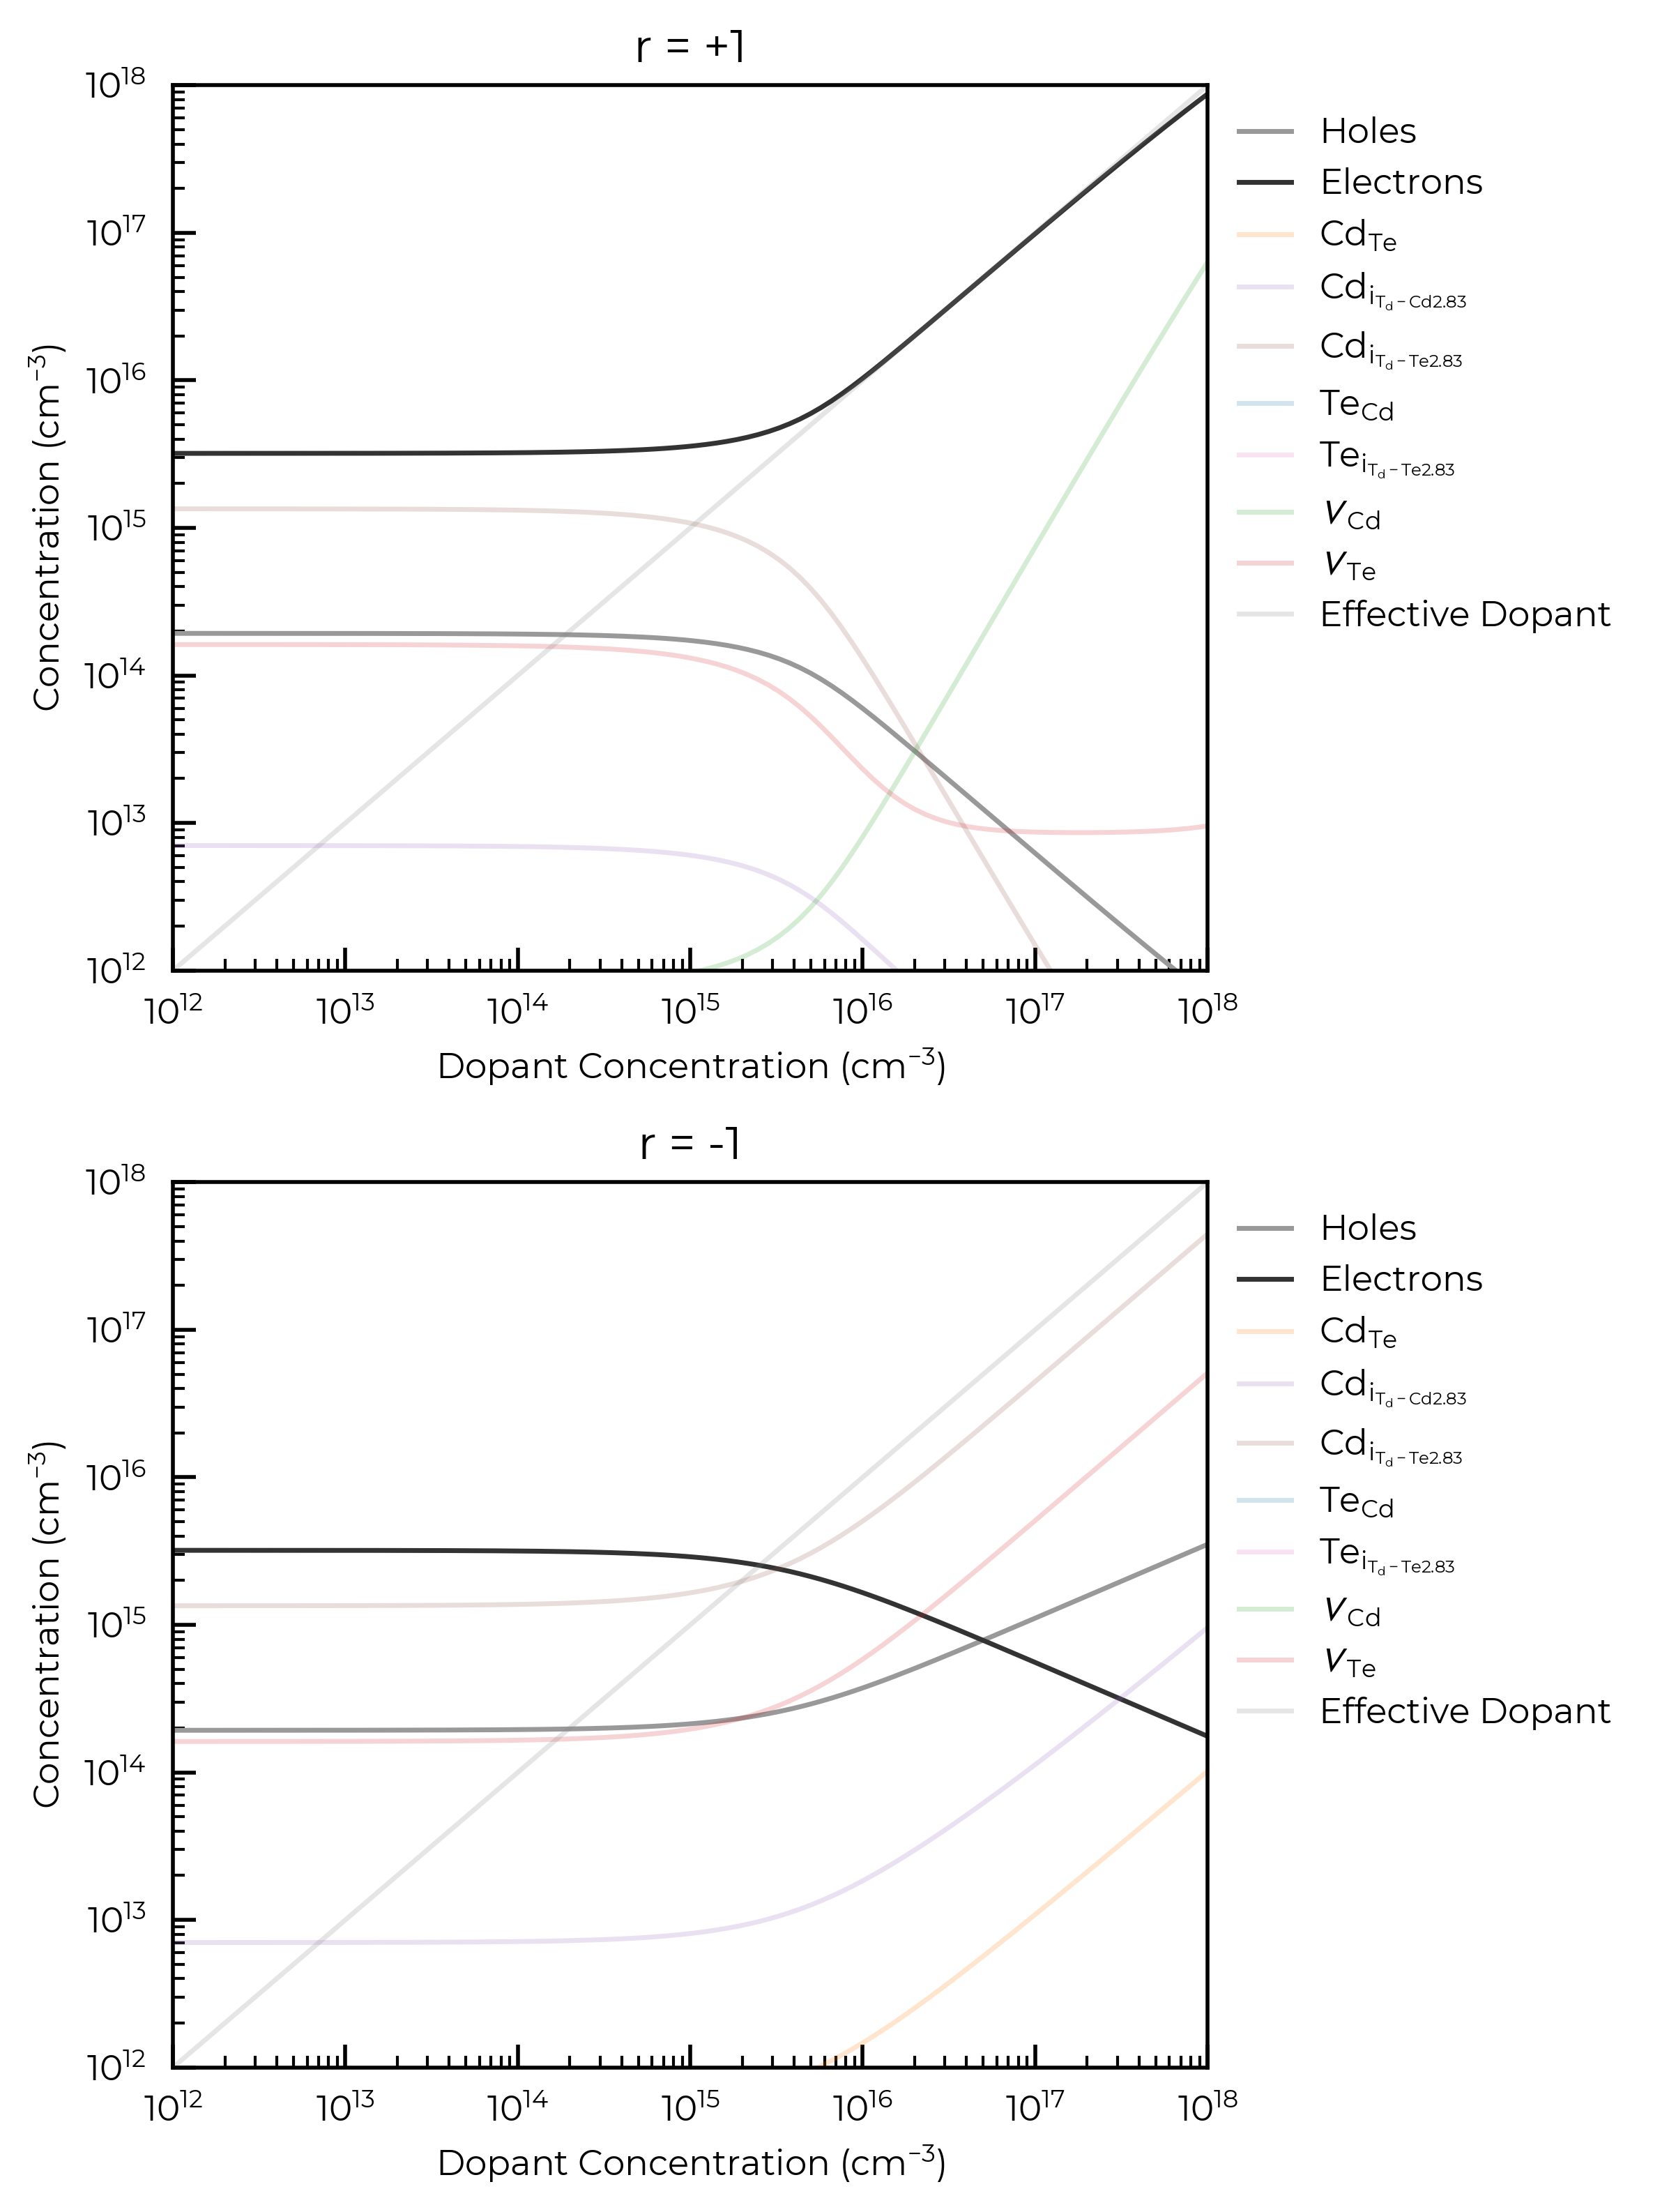

In [3]:
def plot_data(ax, df, concentrations, defect, color):
    """Simple function to handle the plotting in this cell"""
    defect_df = df.loc[defect]
    ax.plot(concentrations, defect_df["Concentration (cm^-3)"], 
            label=format_defect_name(defect, include_site_info_in_name=True, wout_charge=True) or "Effective Dopant", 
            color=color, alpha=0.2)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Dopant Concentration (cm$^{-3}$)")
    ax.set_ylabel("Concentration (cm$^{-3}$)")
    ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))

dopant_concentrations = np.logspace(12, 18, 100)
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# scan a positive and negative effective dopant concentration range - note this can 
# be done with both the doped and py-sc-fermi backends (but not the use of formal/relative
# chempots with doped ('limits_wrt_el_refs'), and raw/DFT chempots with py-sc-fermi ('limits'))
dopant_df_positive = fs.scan_dopant_concentration(chemical_potentials["limits_wrt_el_refs"]["Cd-CdTe"],
                                                      temperature=900, 
                                                      effective_dopant_concentration_range=dopant_concentrations)
dopant_df_negative = fs.scan_dopant_concentration(chemical_potentials["limits_wrt_el_refs"]["Cd-CdTe"], 
                                                     temperature=900, 
                                                     effective_dopant_concentration_range=-dopant_concentrations)

ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Holes (cm^-3)"], label="Holes", color="#999999")
ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Electrons (cm^-3)"], label="Electrons", color="#333333")
ax[1].plot(dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Holes (cm^-3)"], label="Holes", color="#999999")
ax[1].plot(dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Electrons (cm^-3)"], label="Electrons", color="#333333")

for defect in dopant_df_positive.index.unique():
    plot_data(ax[0], dopant_df_positive, dopant_concentrations, defect, defect_colors.get(defect, "gray"))
    ax[0].set_title(f"r = +1")
    plot_data(ax[1], dopant_df_negative, dopant_concentrations, defect, defect_colors.get(defect, "gray"))
    ax[1].set_title(f"r = -1")

ax[0].set_xlim(1e12, 1e18); ax[1].set_xlim(1e12, 1e18); ax[0].set_ylim(1e12, 1e18); ax[1].set_ylim(1e12, 1e18)

plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
plt.show()

The cell below illustrates the same functionality, but we now have an annealing and quenching temperature, this requires minimal changes to the code. The `plot_data` function from the cell above is used again:

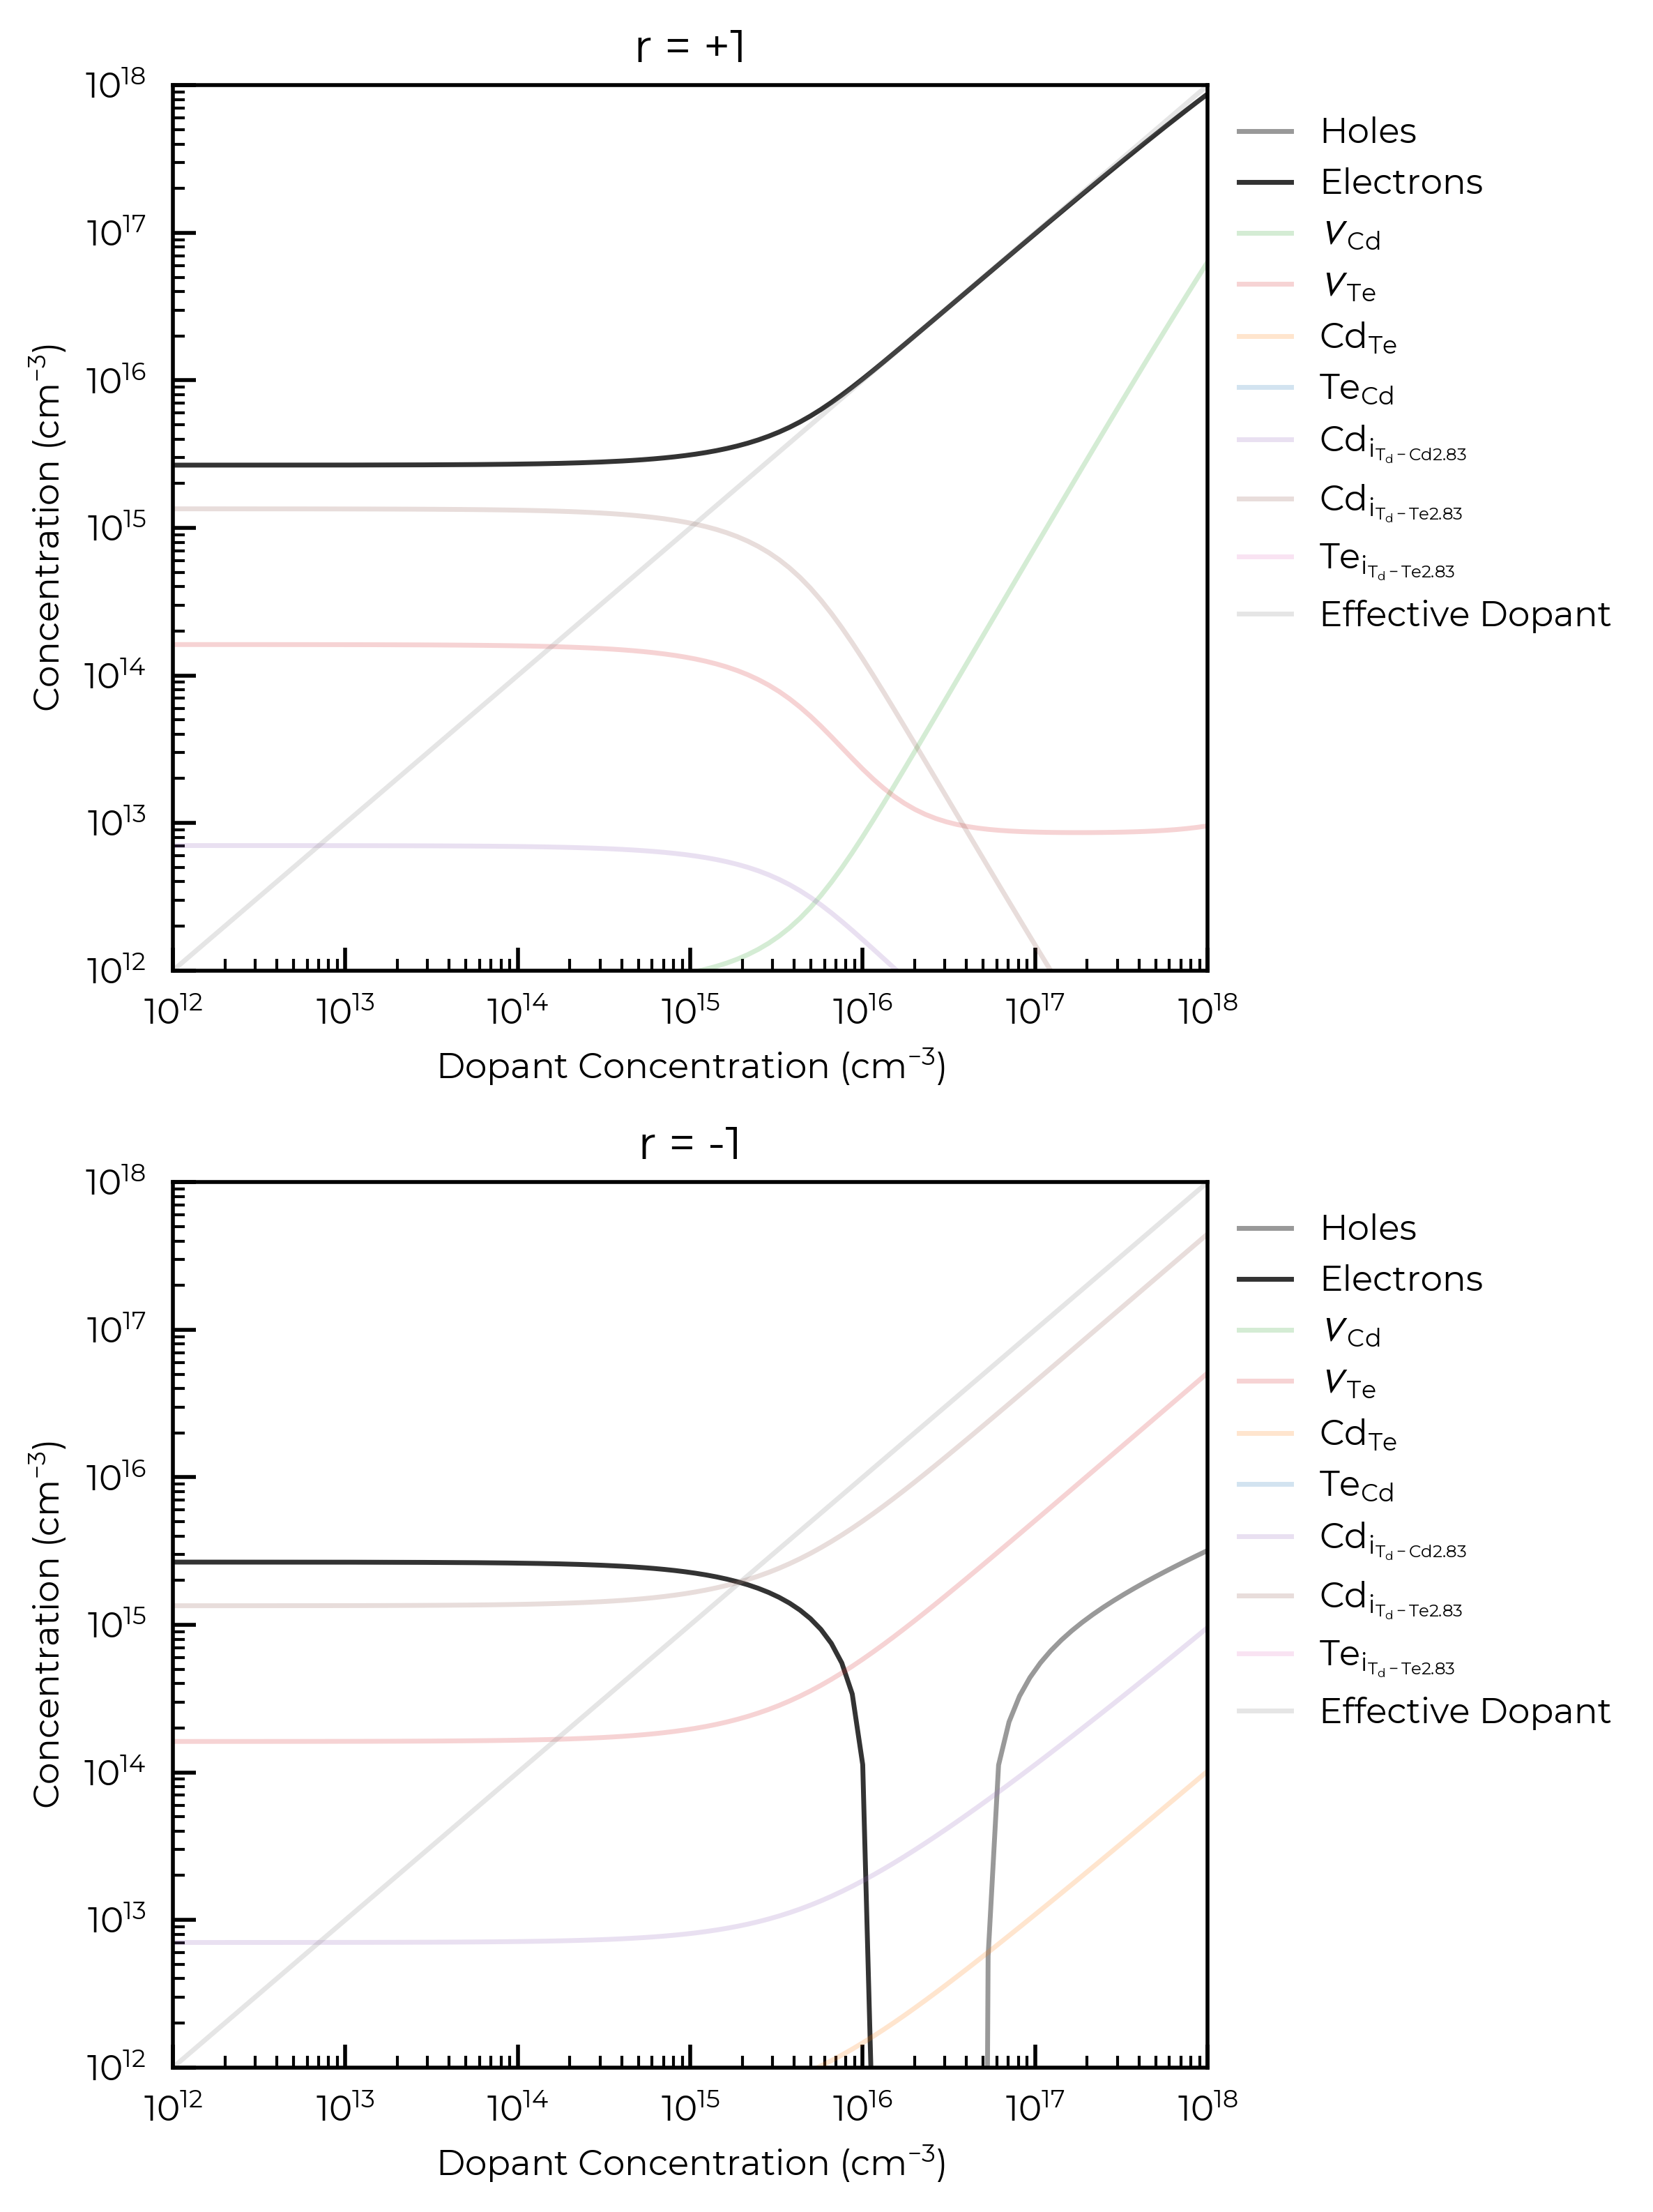

In [4]:
dopant_concentrations = np.logspace(12, 18, 100)
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# the only difference here is that we're scanning over dopant concentration
# having annealed at 900 K and quenched to 300 K
dopant_df_positive = fs.scan_dopant_concentration(chemical_potentials["limits_wrt_el_refs"]["Cd-CdTe"], 
                                                     annealing_temperature = 900, 
                                                     quenching_temperature = 300, 
                                                     effective_dopant_concentration_range=dopant_concentrations)
dopant_df_negative = fs.scan_dopant_concentration(chemical_potentials["limits_wrt_el_refs"]["Cd-CdTe"], 
                                                     quenching_temperature=300, 
                                                     annealing_temperature=900, 
                                                     effective_dopant_concentration_range=-dopant_concentrations)

ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Holes (cm^-3)"], label="Holes", color="#999999")
ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Electrons (cm^-3)"], label="Electrons", color="#333333")
ax[1].plot(dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Holes (cm^-3)"], label="Holes", color="#999999")
ax[1].plot(dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Electrons (cm^-3)"], label="Electrons", color="#333333")

for defect in dopant_df_positive.index.unique():
    plot_data(ax[0], dopant_df_positive, dopant_concentrations, defect, defect_colors.get(defect, "gray"))
    ax[0].set_title(f"r = +1")
    plot_data(ax[1], dopant_df_negative, dopant_concentrations, defect, defect_colors.get(defect, "gray"))
    ax[1].set_title(f"r = -1")

ax[0].set_xlim(1e12, 1e18)
ax[1].set_xlim(1e12, 1e18)
ax[0].set_ylim(1e12, 1e18)
ax[1].set_ylim(1e12, 1e18)

plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
plt.show()

For both donor and acceptor dopants here, we see that a concentration >10$^{15}$ cm$^{-3}$ is required to significantly affect the Fermi level and thus carrier and intrinsic defect concentrations, for an annealing temperature of 900 K.  

### Custom Concentration/Equilibration Constraints 

One thing we can do in `py-sc-fermi` is specify defects to be excluded from the 'frozen defect' approximation (i.e. the assumption that the total defect concentration will remain fixed at the high temperature value). This is useful in systems where we expect barriers for some defect recombination to be low. Take the example of an ion conductor, if interstitials of the mobile ion $M$ form at high temperature, it may be unreasonable to assume these defects cannot then move into vacant $M$ sites on cooling. 

To explore these kinds of _what if_ situations, all the quenching & annealing `FermiSolverPyScFermi` methods can accept an additional `exceptions` argument, which specifies defects that are allowed to fully re-equilibrate at the quenched temperature (i.e. for which the 'frozen defect' approximation is not applied). The cell below shows this hypothetical example where the Te interstitials ([known](https://pubs.rsc.org/en/content/articlelanding/2022/fd/d2fd00043a) to be highly-mobile) and vacancies are allowed to recombine on cooling, but the total concentrations of all other defects remain fixed at the high temperature values ('frozen defect' approximation).

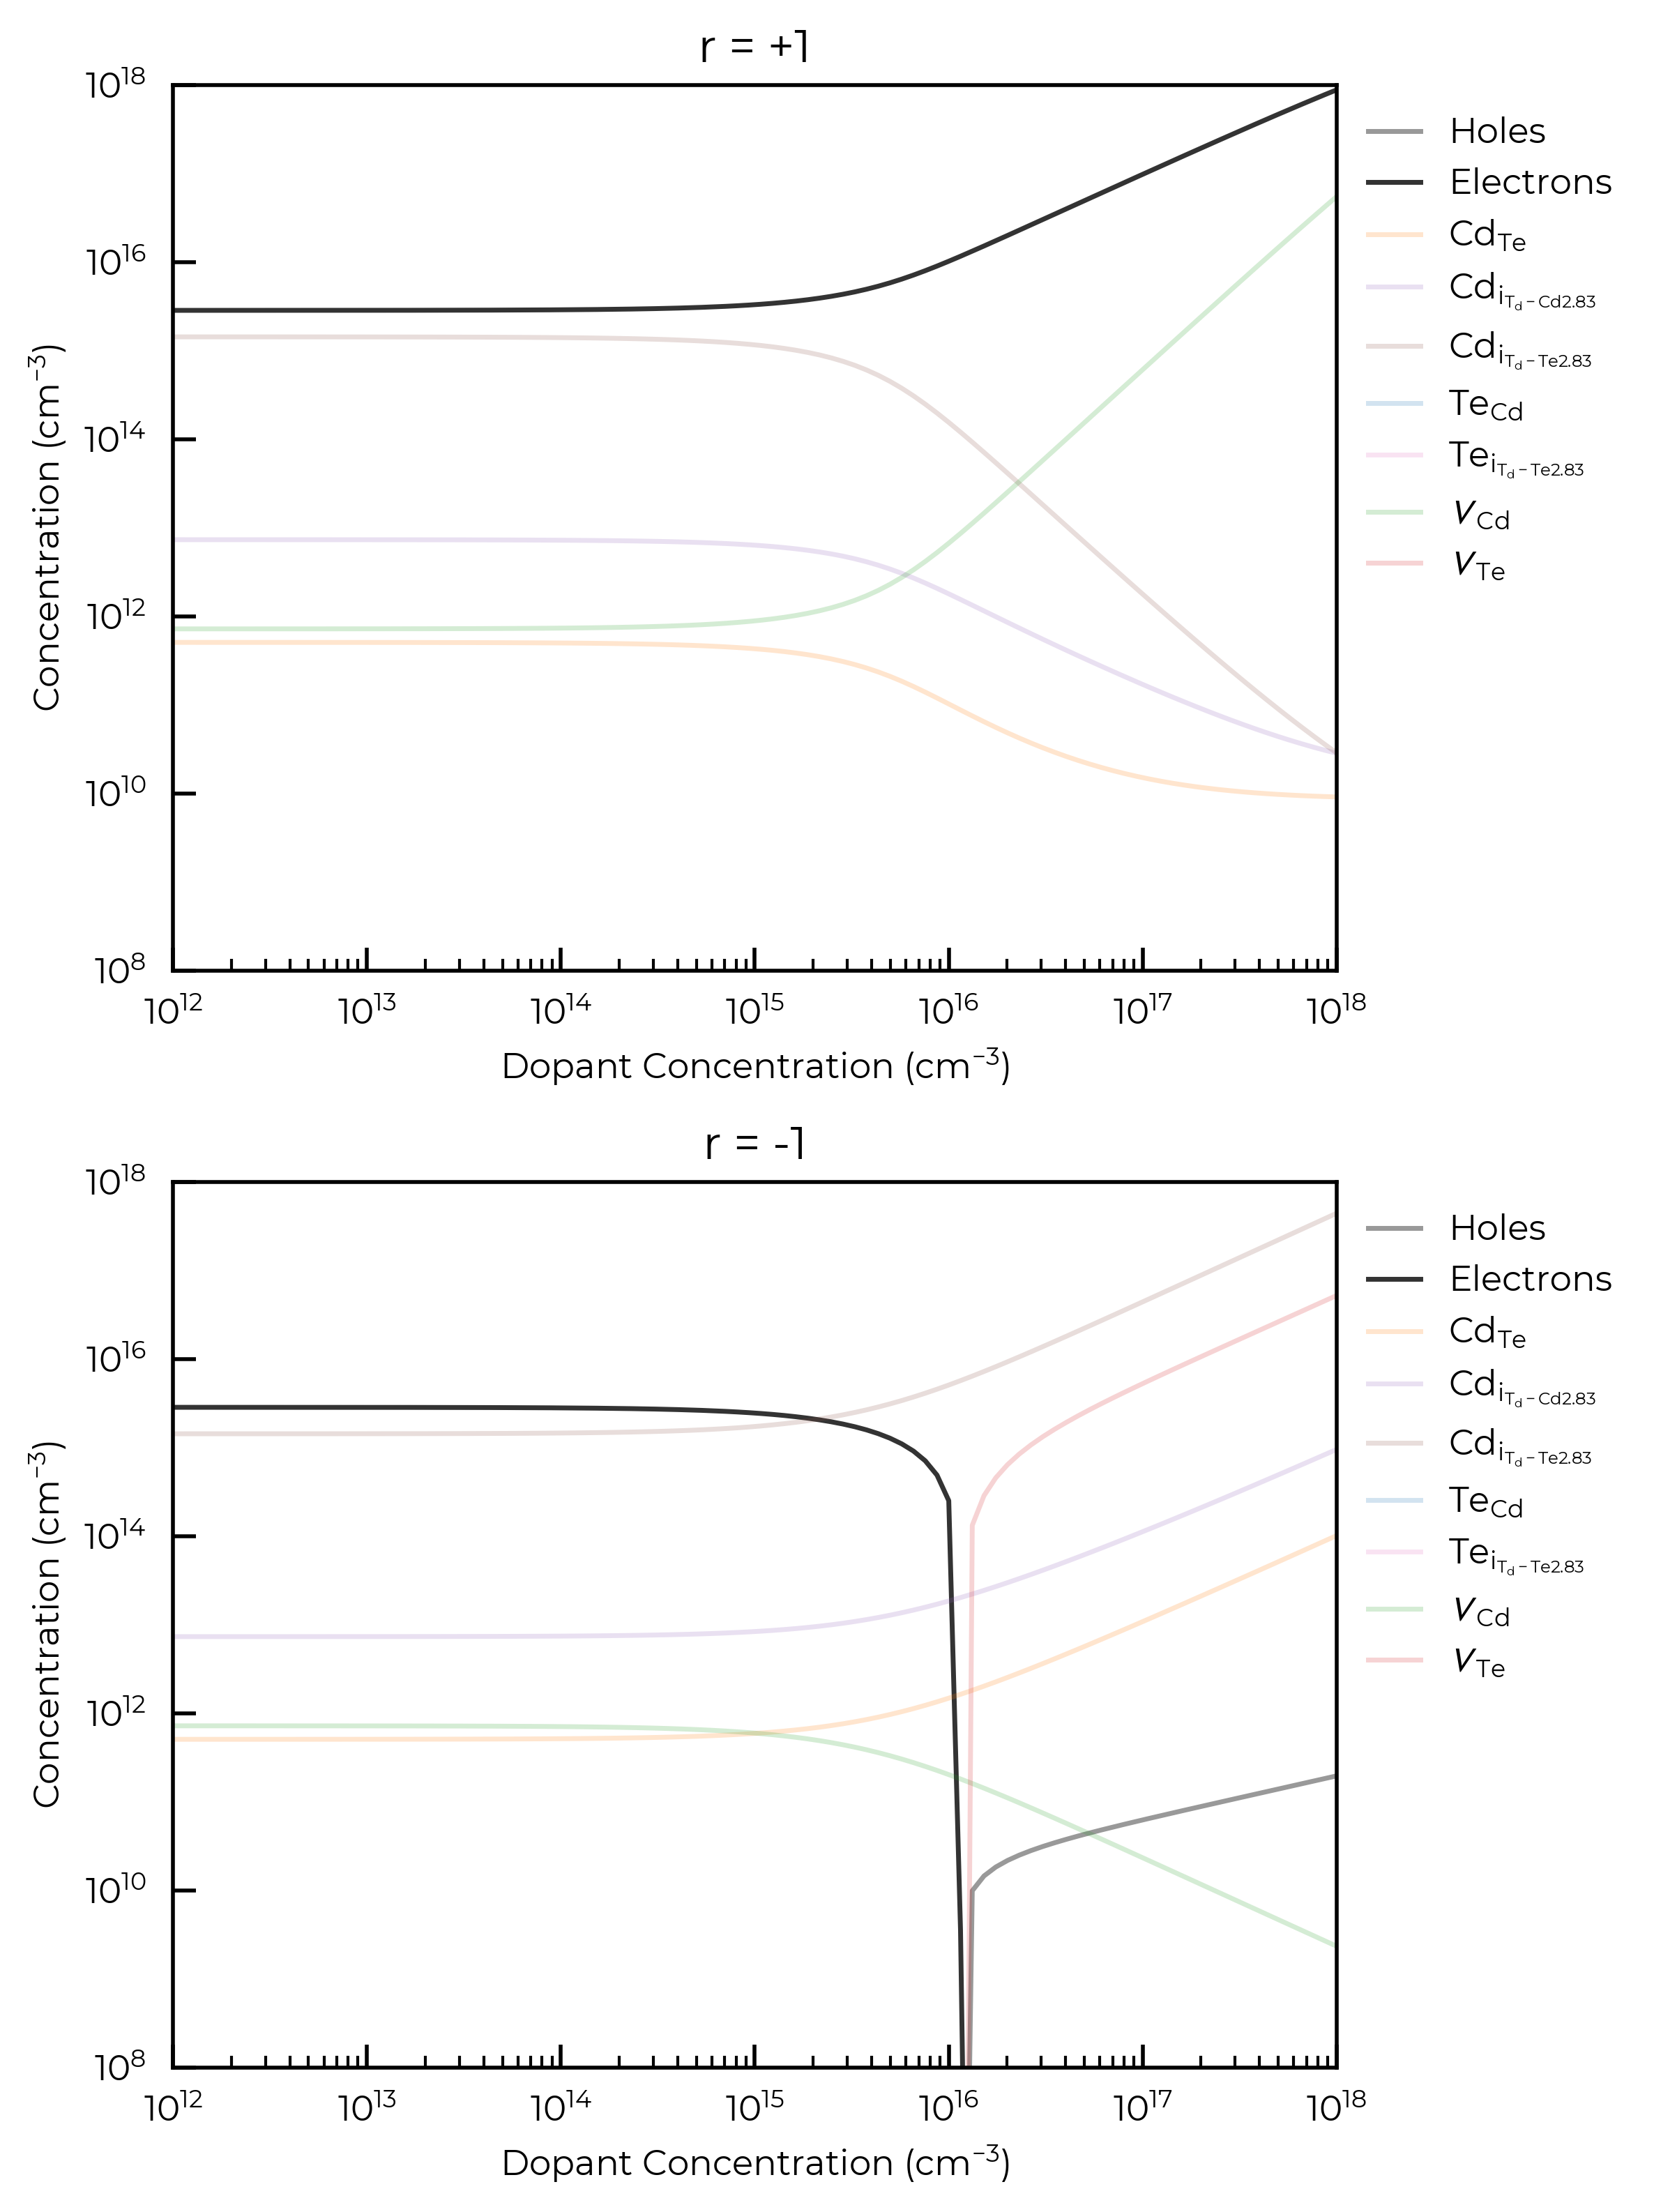

In [10]:
dopant_concentrations = np.logspace(12, 18, 100)
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

dopant_df_positive = py_fs.scan_dopant_concentration(chemical_potentials["limits"]["Cd-CdTe"], 
                                                                            annealing_temperature=900, 
                                                                            quenching_temperature=300, 
                                                                            effective_dopant_concentration_range=dopant_concentrations, 
                                                                            exceptions = ["Te_i_Td_Te2.83", "v_Te"])
dopant_df_negative = py_fs.scan_dopant_concentration(chemical_potentials["limits"]["Cd-CdTe"], 
                                                                            quenching_temperature=300,
                                                                            annealing_temperature=900, 
                                                                            effective_dopant_concentration_range=-dopant_concentrations, 
                                                                            exceptions = ["Te_i_Td_Te2.83", "v_Te"])

ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Holes (cm^-3)"], label="Holes", color="#999999")
ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Electrons (cm^-3)"], label="Electrons", color="#333333")
ax[1].plot(dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Holes (cm^-3)"], label="Holes", color="#999999")
ax[1].plot(dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Electrons (cm^-3)"], label="Electrons", color="#333333")

for defect in unique_defects:
    plot_data(ax[0], dopant_df_positive, dopant_concentrations, defect, defect_colors[defect])
    ax[0].set_title(f"r = +1")
    plot_data(ax[1], dopant_df_negative, dopant_concentrations, defect, defect_colors[defect])
    ax[1].set_title(f"r = -1")

ax[0].set_xlim(1e12, 1e18); ax[1].set_xlim(1e12, 1e18)
ax[0].set_ylim(1e8, 1e18); ax[1].set_ylim(1e8, 1e18)

plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
plt.show()

As an additional, purely-illustrative example, the below code cell shows the case where vacancies and antisites are allowed to recombine upon cooling, while interstitials are kept fixed at their high temperature concentrations:  

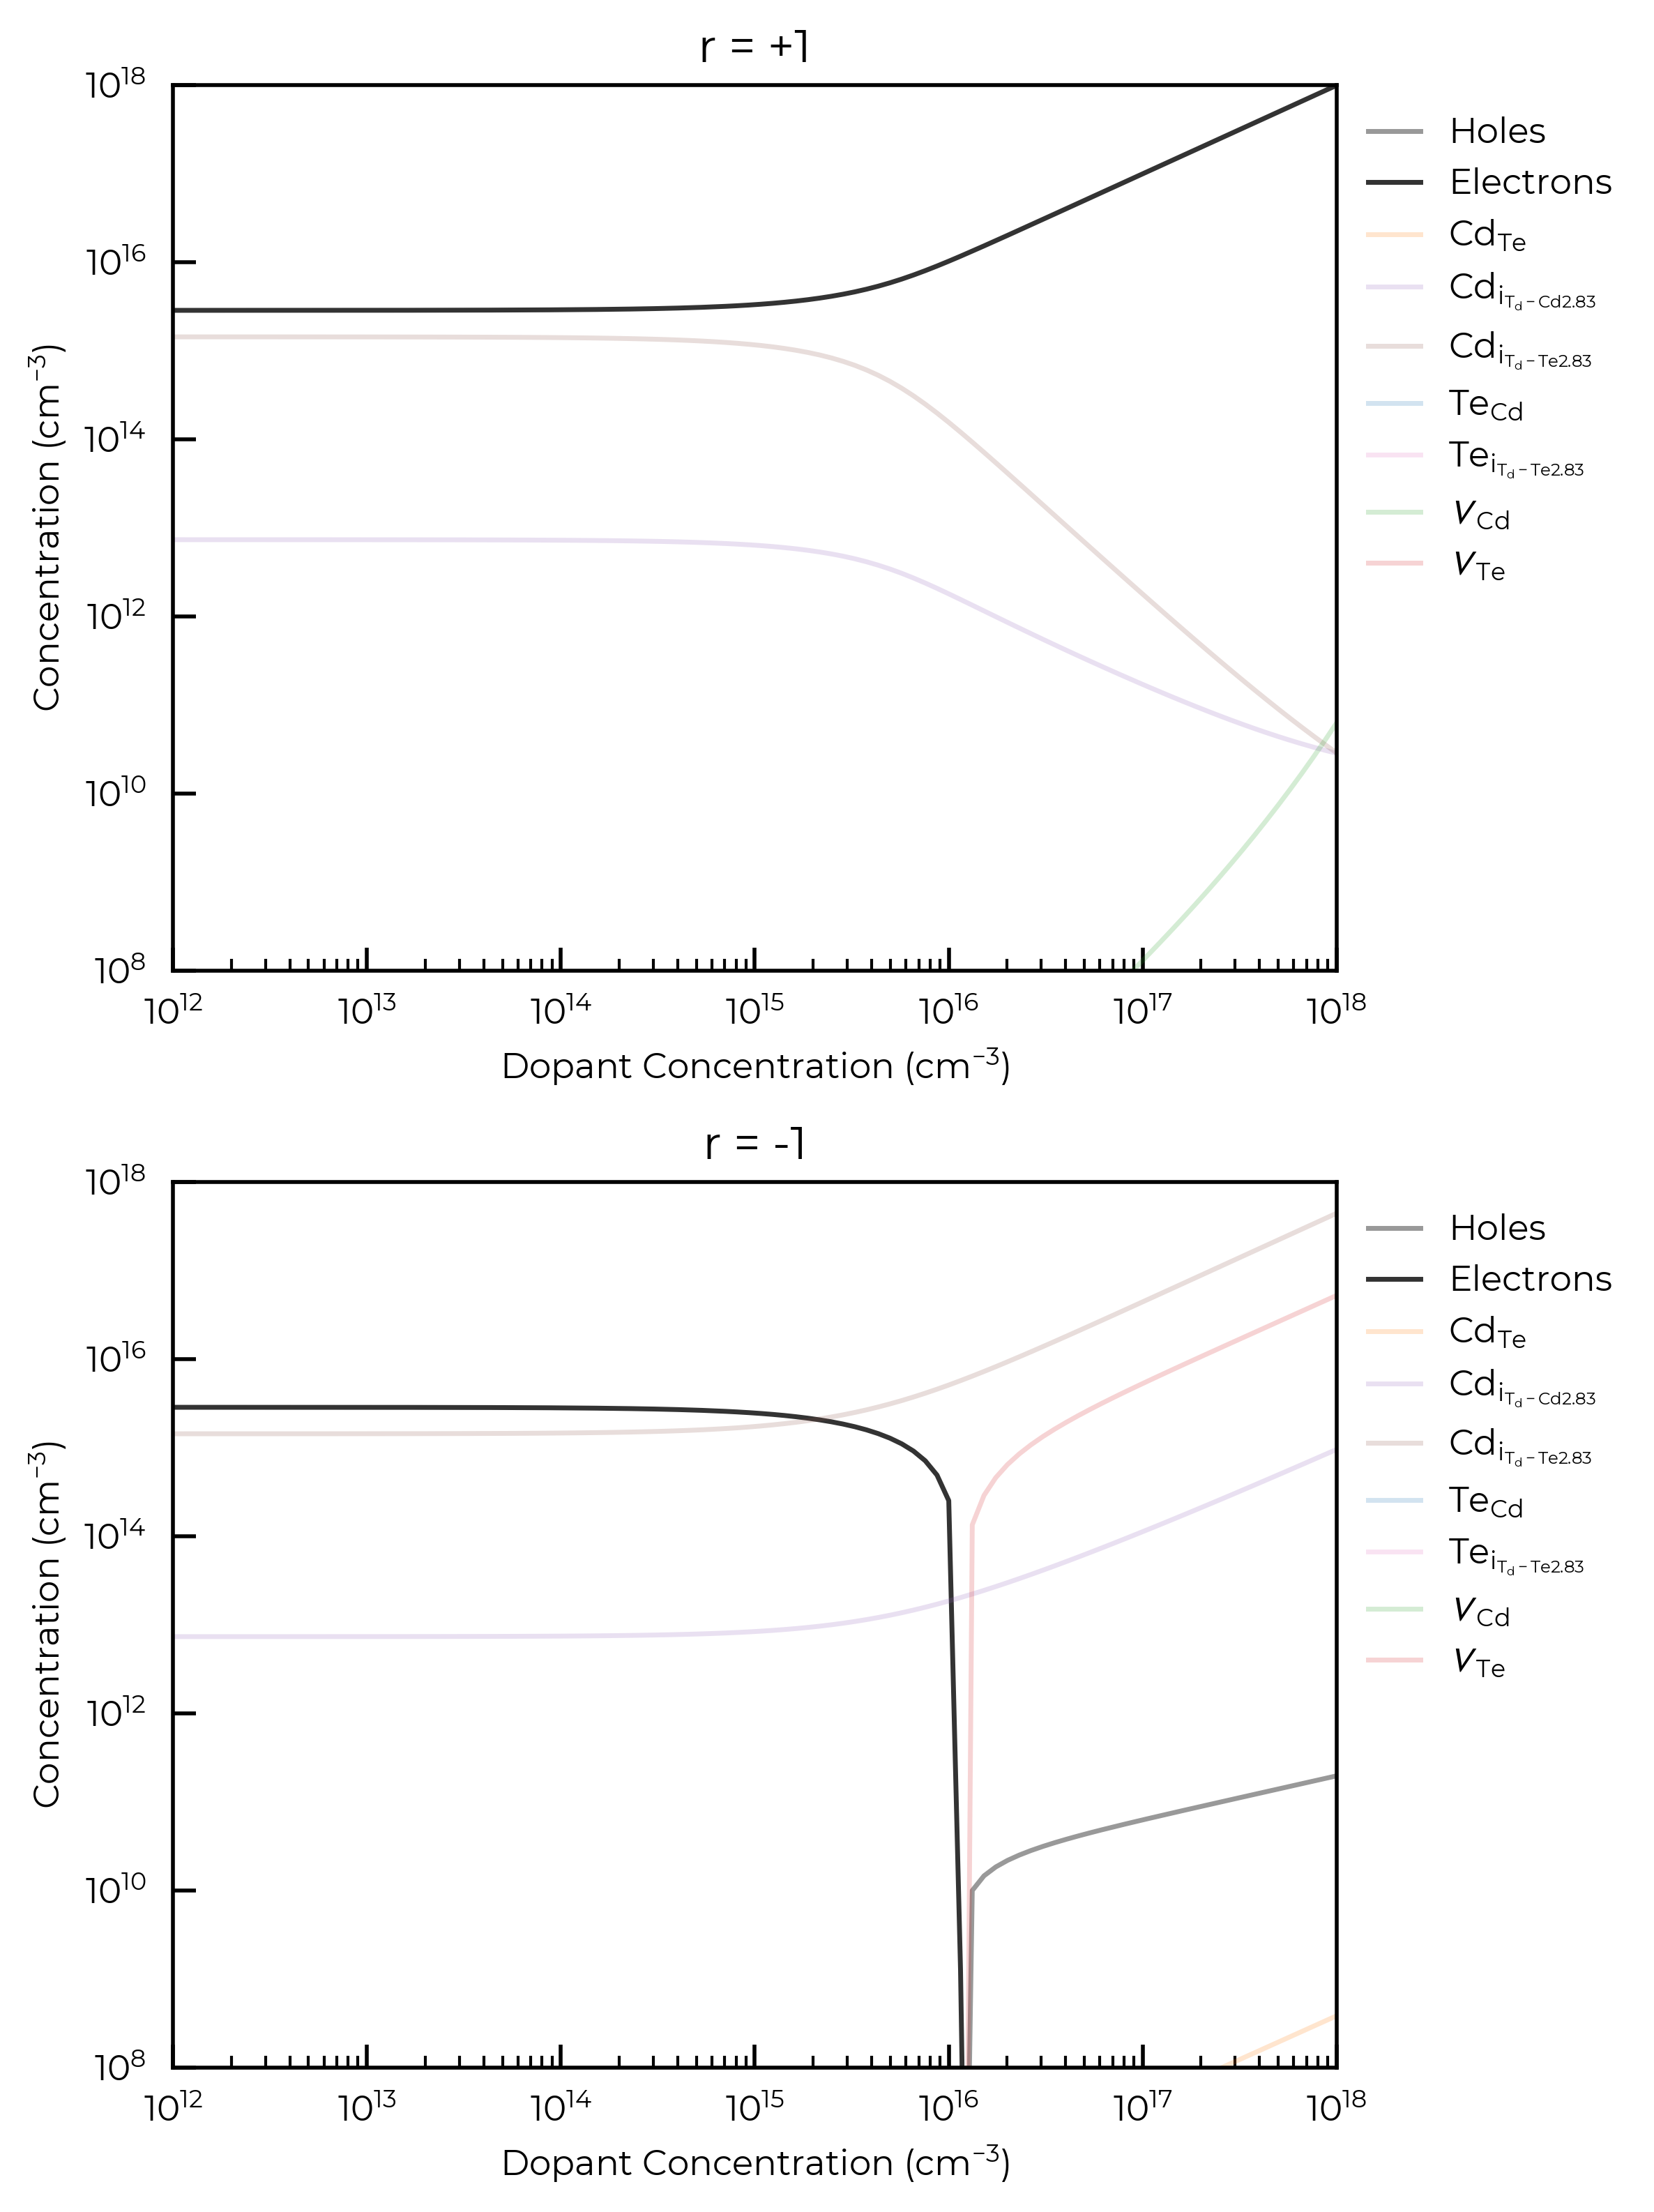

In [11]:
dopant_concentrations = np.logspace(12, 18, 100)
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

dopant_df_positive = py_fs.scan_dopant_concentration(chemical_potentials["limits"]["Cd-CdTe"], 
                                                                            annealing_temperature=900, 
                                                                            quenching_temperature=300, 
                                                                            effective_dopant_concentration_range=dopant_concentrations, 
                                                                            exceptions = ["Cd_Te", "v_Cd", "Te_Cd", "v_Te"])
dopant_df_negative = py_fs.scan_dopant_concentration(chemical_potentials["limits"]["Cd-CdTe"], 
                                                                            quenching_temperature=300,
                                                                            annealing_temperature=900, 
                                                                            effective_dopant_concentration_range=-dopant_concentrations, 
                                                                            exceptions = ["Cd_Te", "v_Cd", "Te_Cd", "v_Te"])

ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Holes (cm^-3)"], label="Holes", color="#999999")
ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Electrons (cm^-3)"], label="Electrons", color="#333333")
ax[1].plot(dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Holes (cm^-3)"], label="Holes", color="#999999")
ax[1].plot(dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Electrons (cm^-3)"], label="Electrons", color="#333333")

for defect in unique_defects:
    plot_data(ax[0], dopant_df_positive, dopant_concentrations, defect, defect_colors[defect])
    ax[0].set_title(f"r = +1")
    plot_data(ax[1], dopant_df_negative, dopant_concentrations, defect, defect_colors[defect])
    ax[1].set_title(f"r = -1")

ax[0].set_xlim(1e12, 1e18); ax[1].set_xlim(1e12, 1e18)
ax[0].set_ylim(1e8, 1e18); ax[1].set_ylim(1e8, 1e18)

plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
plt.show()

### Cu<sub>2</sub>SiSe<sub>3</sub>: 2D Chemical Potential Scans

One thing that has been added with the `FermiSolver` class is the ability to simply perform scans over >2d chemical potential spaces, this is outlined for Cu<sub>2</sub>SiSe<sub>3</sub> in the cells below.

In [8]:
from doped.interface.fermi_solver import FermiSolverDoped  # with doped backend here:
from monty.serialization import loadfn
import matplotlib.pyplot as plt

# we can use the doped style file to make all our plots look consistent
style_file = "../doped/utils/doped.mplstyle"
plt.style.use(style_file)

# we need to specify the path to the vasprun.xml(.gz) file
# that was used for the DOS calculation. This is because
# we need to accurately account for the electronic carrier concentrations
# as well as the defect concentrations to determine the Fermi level
vasprun_path = "Cu2SiSe3/vasprun.xml.gz"

# the DefectThermodynamics object contains all the information about the
# defect formation energies and transition levels. It will underpin both the
# doped and py-sc-fermi solvers
thermodynamics = loadfn("Cu2SiSe3/Cu2SiSe3_thermo.json")

# and the chemical potentials can then be used to specify the
# defect formation energies under different conditions, and act as a parameter
# space we can scan over to interrogate the defect concentrations
chemical_potentials = loadfn("Cu2SiSe3/Cu2SiSe3_chempots.json")

# initialize the FermiSolver objects.
# first we initialize the FermiSolver object
fs = FermiSolverDoped(defect_thermodynamics=thermodynamics, 
                        bulk_dos_vr=vasprun_path)

data = fs.scan_chemical_potential_grid(chemical_potentials, 
                                        dependent_variable="Se",    # the dependent variable is the name of the dependent chemical potential
                                        n_points=20,                # n_points in each dimension when scanning over the chemical potential grid
                                        annealing_temperature=1000, # the temperature at which to anneal the system
                                        quenching_temperature=300,  # the temperature at which to quench the system
                                        processes=4)                # the number of processes to use when scanning over the chemical potential grid

ValueError: f(a) and f(b) must have different signs

In [17]:
from doped.interface.fermi_solver import FermiSolverPyScFermi
from monty.serialization import loadfn
import matplotlib.pyplot as plt

# we can use the doped style file to make all our plots look consistent
style_file = "../doped/utils/doped.mplstyle"
plt.style.use(style_file)

# we need to specify the path to the vasprun.xml(.gz) file
# that was used for the DOS calculation. This is because
# we need to accurately account for the electronic carrier concentrations
# as well as the defect concentrations to determine the Fermi level
vasprun_path = "Cu2SiSe3/vasprun.xml.gz"

# the DefectThermodynamics object contains all the information about the
# defect formation energies and transition levels. It will underpin both the
# doped and py-sc-fermi solvers
thermodynamics = loadfn("Cu2SiSe3/Cu2SiSe3_thermo.json")

# and the chemical potentials can then be used to specify the
# defect formation energies under different conditions, and act as a parameter
# space we can scan over to interrogate the defect concentrations
chemical_potentials = loadfn("Cu2SiSe3/Cu2SiSe3_chempots.json")

# initialize the FermiSolver objects.
# first we initialize the FermiSolver object
fs = FermiSolverPyScFermi(defect_thermodynamics=thermodynamics, 
                        bulk_dos_vr=vasprun_path)

data = fs.scan_chemical_potential_grid(chemical_potentials, 
                                        dependent_variable="Se",    # the dependent variable is the name of the dependent chemical potential
                                        n_points=20,                # n_points in each dimension when scanning over the chemical potential grid
                                        annealing_temperature=1000, # the temperature at which to anneal the system
                                        quenching_temperature=300,  # the temperature at which to quench the system
                                        processes=4)                # the number of processes to use when scanning over the chemical potential grid

This can then be used to plot a variable of interest over the calculated points.

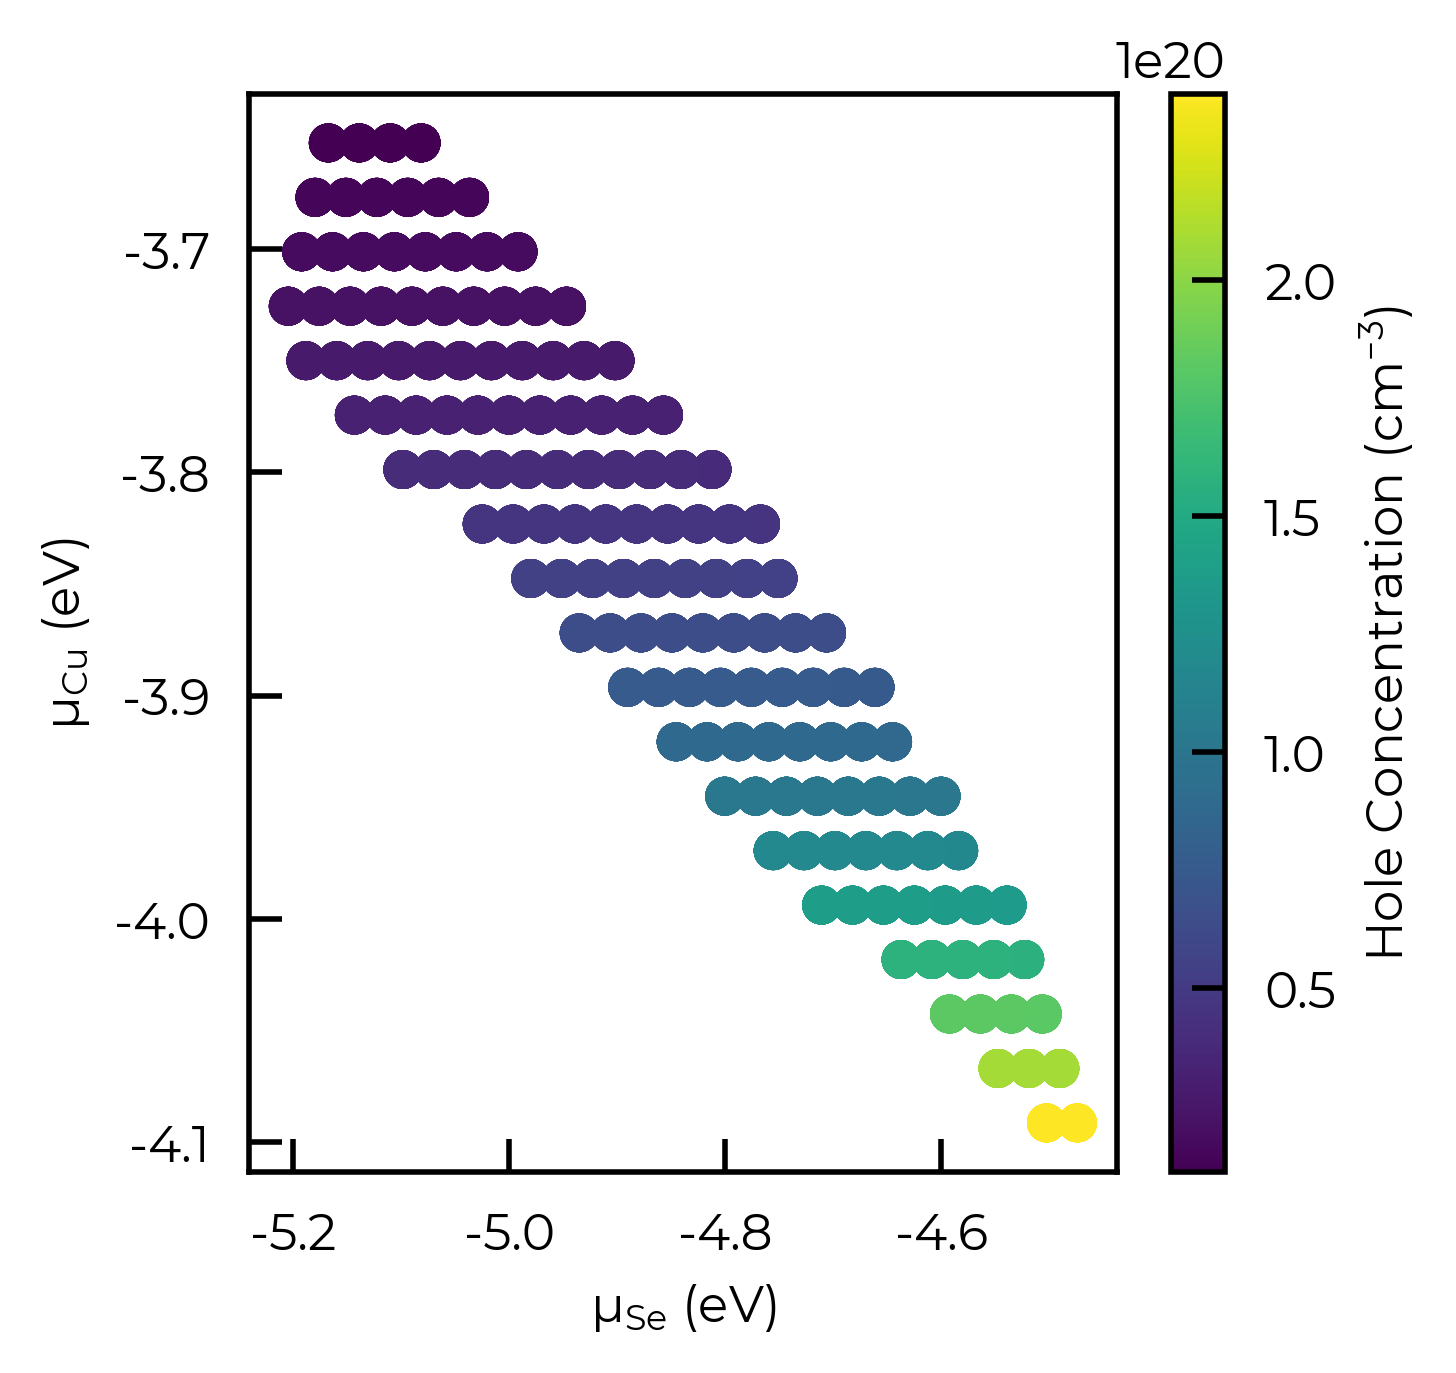

In [21]:
from matplotlib.colors import LogNorm

plt.scatter(data["Se"], data["Cu"], c=data["Holes (cm^-3)"], cmap='viridis')

cbar = plt.colorbar(label="Hole Concentration (cm$^{-3}$)", norm=LogNorm(min(data["Holes (cm^-3)"]), max(data["Holes (cm^-3)"])))

plt.xlabel("$\mu_{Se}$ (eV)")
plt.ylabel("$\mu_{Cu}$ (eV)")
plt.show()

In this final cell, we show a tool for investigating complex chemical potential spaces. For a target value (hole, electron, or a specific defect concentration, or the Fermi energy) we find the position in chemical potential space where that target value is minimised or maximised. This is done by carrying out a coarse interpolation in chemical potential space, and finding an initial point at which the target value is minimised or maximised. A new chemical potential grid is then generated centered on this new value and the search repeated. This is done until the change in the target value is smaller than a provided tolerance factor. The output of the code is a dataframe that describes the defect system at the identified chemical potential. Example useage is shown in the cell below

In [19]:
df_defect_system = fs.min_max_X(chemical_potentials=chemical_potentials,  # the chemical potentials to scan over
                dependent_chempot="Se",  # the dependent chemical potential
                target="Holes (cm^-3)",  # the target variable
                min_or_max="max",  # whether to find the minimum or maximum of the target variable
                tolerance=0.001, # the tolerance for the target variable
                annealing_temperature=1000, 
                quenching_temperature=300, 
                processes=4)
print(df_defect_system)

        Annealing Temperature  Quenched Temperature  Fermi Level  \
Defect                                                             
v_Cu_2                   1000                   300    -0.102718   
Int_Si                   1000                   300    -0.102718   
Cu_Si                    1000                   300    -0.102718   
v_Si                     1000                   300    -0.102718   
Se_Cu                    1000                   300    -0.102718   
Si_Cu                    1000                   300    -0.102718   
Se_Si                    1000                   300    -0.102718   
Int_Cu                   1000                   300    -0.102718   
Si_Se                    1000                   300    -0.102718   
Int_Se                   1000                   300    -0.102718   
v_Cu_1                   1000                   300    -0.102718   
v_Se                     1000                   300    -0.102718   

        Holes (cm^-3)  Electrons (cm^-3)  Conce